In [410]:
%pip install tqdm scikit-learn pandas matplotlib seaborn pyarrow xgboost
%pip install torch --index-url https://download.pytorch.org/whl/cu118

# Homework 2: Decision Trees
## Task 1: Implement a Decision Tree Classifier

In [411]:
from sklearn import tree
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import xgboost as xgb
import torch

seed = 42

Label split %: diagnosis
0    0.627417
1    0.372583
Name: count, dtype: float64


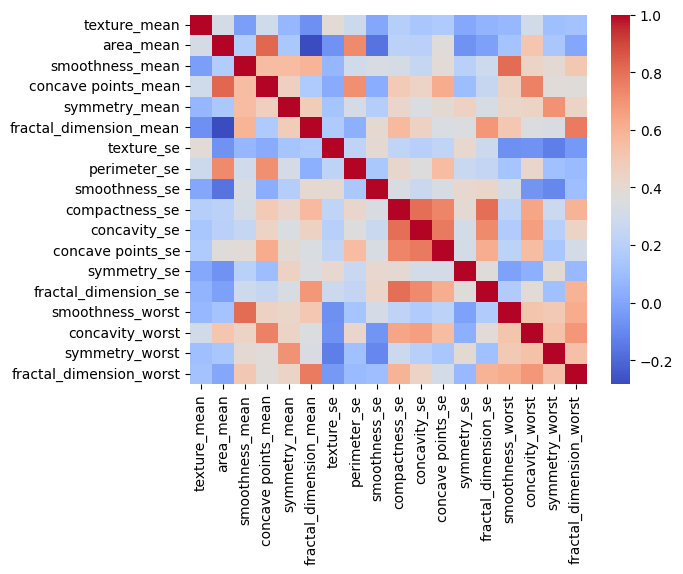

In [412]:
# Load data
data_dir = "data/breast-cancer.csv"
data = pd.read_csv(data_dir)

# Converting lablels to 0 and 1
labels = data["diagnosis"]
labels = labels.map({"B": 0, "M": 1})
data = data.drop(["id", "diagnosis"], axis=1)
data = data.astype(float)
print(f"Label split %: {labels.value_counts() / len(labels)}")

# Removing highly correlated features and correlating again
data = data.drop(["radius_mean", "perimeter_mean", "radius_se", "area_se", "radius_worst", "perimeter_worst", "compactness_mean", "concavity_mean", "concave points_worst", "compactness_worst", "texture_worst", "area_worst"], axis=1)
new_corr = data.corr()
sns.heatmap(new_corr, cmap="coolwarm", xticklabels=True, yticklabels=True)
plt.show()

In [413]:
# Train and test split to avoid overfitting
X_train_, X_test_, y_train_, y_test_ = train_test_split(torch.tensor(data.values), torch.tensor(labels.values), test_size=0.2, random_state=seed)

# Normalize the data to avoid gradient explosion and vanishing
mean = X_train_.mean()
std = X_train_.std()
X_train_ = (X_train_ - mean) / std
X_test_ = (X_test_ - mean) / std

In [414]:
# Decision tree
clf_1 = tree.DecisionTreeClassifier(random_state=seed)
clf_1 = clf_1.fit(X_train_, y_train_)
print(f"Train accuracy: {clf_1.score(X_train_, y_train_)}")
print(f"Test accuracy: {clf_1.score(X_test_, y_test_)}")

Train accuracy: 1.0
Test accuracy: 0.9035087719298246


In [415]:
# Decision tree with one hyperparameter changed
clf_2 = tree.DecisionTreeClassifier(random_state=seed, max_depth=4)
clf_2 = clf_2.fit(X_train_, y_train_)
print(f"Train accuracy: {clf_2.score(X_train_, y_train_)}")
print(f"Test accuracy: {clf_2.score(X_test_, y_test_)}")

Train accuracy: 0.9758241758241758
Test accuracy: 0.956140350877193


Clearly the first tree overfit on the data because it was able to get 100% accuracy but only 90% on the test set.
By limiting the max depth of the tree, we limit the overfitting of the tree on the training data. This is effectively regularizing it and
it was able to generalize well as seen by the test accuracy being higher.

## Task 2: Bagging and Boosting
For this task I chose RandomForest as my bagging method and XGBoost as my boosting method.

In [416]:
clf = RandomForestClassifier(random_state=seed)
results = cross_validate(clf, X_train_, y_train_, cv=10, scoring="accuracy", return_estimator=True)
estimators = results["estimator"]
scores = results["test_score"]
best_idx = np.argmax(scores)
clf_3, best_score = estimators[best_idx], scores[best_idx]

print(f"Train accuracy: {clf_3.score(X_train_, y_train_)}")
print(f"Validation accuracy: {best_score}")
print(f"Test accuracy: {clf_3.score(X_test_, y_test_)}")

Train accuracy: 0.9978021978021978
Validation accuracy: 0.9782608695652174
Test accuracy: 0.9473684210526315


In [417]:
clf = xgb.XGBClassifier(random_state=seed)
results = cross_validate(clf, X_train_, y_train_, cv=10, scoring="accuracy", return_estimator=True)
estimators = results["estimator"]
scores = results["test_score"]
best_idx = np.argmax(scores)
clf_4, best_score = estimators[best_idx], scores[best_idx]

print(f"Train accuracy: {clf_4.score(X_train_, y_train_)}")
print(f"Validation accuracy: {best_score}")
print(f"Test accuracy: {clf_4.score(X_test_, y_test_)}")

Train accuracy: 1.0
Validation accuracy: 1.0
Test accuracy: 0.9649122807017544


Both the random forest and xgboost models perform well on the test set meaning they are able to generalize well.
However, the xgboost model performs slightly better than the random forest model.
But, This could be due to random noise since they are only 1% apart.

## Task 3: Comparison

I am using the accuracy on the test set to use for comparison. The reason this is useful for the comparison
is because the models have not seen the test set before so they must be able to generalize in order to
get good accuracy. A different metric or ensemble of metrics could be useful because of the nature of the
dataset being slightly imbalanced (about 63/37 split). 

Just looking at the accuracy, we can see that the XGBoost model performed the best on the test set.

In [418]:
def do_testing(y_pred_):
    true_pos = torch.sum((y_pred_ > 0.5) & y_test_.bool())
    true_neg = torch.sum((y_pred_ <= 0.5) & (y_test_.bool() == False))
    false_pos = torch.sum((y_pred_ > 0.5) & (y_test_.bool() == False))
    false_neg = torch.sum((y_pred_ <= 0.5) & y_test_.bool())
    total = y_pred_.shape[0]

    def accuracy():
        return (true_pos + true_neg) / total
    
    def precision():
        return true_pos / (true_pos + false_pos)
    
    def recall():
        return true_pos / (true_pos + false_neg)
    
    def f1():
        return 2 * precision() * recall() / (precision() + recall())
    
    def specificity():
        return true_neg / (true_neg + false_pos)
    
    eval_values = [accuracy(), precision(), recall(), f1(), specificity()]
    return torch.Tensor(eval_values)

summary = torch.zeros((4, 5))
summary[0] = do_testing(torch.tensor(clf_1.predict(X_test_)))
summary[1] = do_testing(torch.tensor(clf_2.predict(X_test_)))
summary[2] = do_testing(torch.tensor(clf_3.predict(X_test_)))
summary[3] = do_testing(torch.tensor(clf_4.predict(X_test_)))
df = pd.DataFrame(summary, index=["Tree", "Tree max_depth=4", "Random Forest", "XGBoost"], columns=["Accuracy", "Precision", "Recall", "F1", "Specificity"])
cm = sns.light_palette("green", as_cmap=True)
df.style.background_gradient(cmap=cm, axis=0).format("{:.2%}").highlight_max(axis=0, color="blue")

,Accuracy,Precision,Recall,F1,Specificity
Tree,90.35%,84.78%,90.70%,87.64%,90.14%
Tree max_depth=4,95.61%,95.24%,93.02%,94.12%,97.18%
Random Forest,94.74%,95.12%,90.70%,92.86%,97.18%
XGBoost,96.49%,97.56%,93.02%,95.24%,98.59%


We can see that for most evaluation metrics the outputs reflect the same conclusion as the accuracy, that the XGBoost model performed the best out of all 4 models.

# Task 4: Hyperparam Tuning (Graduate Only)
I will be using a randomized search in order to find the best value for 3 hyperparameters for XGBoost. I think that the values that the parameters that control regularization and learning rate will help to find the best hyperparameters for a model.
- max_depth: how many layers the tree is able to go down to
  - this is effectively a regularizer because it helps to prevent overfitting by making sure the model generalizes
- lambda: the regularization parameter for the L2 loss in gradient boosting
  - this controls the size of the weights for the gradient boosting in XGBoost
- eta: step size for the gradient boosting
  - controlling this makes sure that we are finding the best local minimum in a optimal time

In [419]:
xgb_clf = xgb.XGBClassifier(random_state=seed)
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
param_grid = {
    "max_depth": np.linspace(1, 10, 30, endpoint=True, dtype=int),
    "eta": np.logspace(-3, 1, 30, endpoint=True, base=10),
    "lambda": np.logspace(-3, 0, 30, endpoint=True, base=10),
}

clf = RandomizedSearchCV(xgb_clf, param_grid, cv=cv, scoring="accuracy", n_jobs=-1, random_state=seed)
clf.fit(X_train_, y_train_)
print(clf.best_params_)

{'max_depth': 7, 'lambda': 0.14873521072935117, 'eta': 0.3039195382313198}


In [420]:
new_summary = torch.vstack((summary, do_testing(torch.tensor(clf.predict(X_test_)))))
df = pd.DataFrame(new_summary, index=["Tree", "Tree max_depth=4", "Random Forest", "XGBoost", "Hyperparam tuned"], columns=["Accuracy", "Precision", "Recall", "F1", "Specificity"])
cm = sns.light_palette("green", as_cmap=True)
df.style.background_gradient(cmap=cm, axis=0).format("{:.2%}").highlight_max(axis=0, color="blue")

,Accuracy,Precision,Recall,F1,Specificity
Tree,90.35%,84.78%,90.70%,87.64%,90.14%
Tree max_depth=4,95.61%,95.24%,93.02%,94.12%,97.18%
Random Forest max_depth=4,94.74%,95.12%,90.70%,92.86%,97.18%
XGBoost max_depth=4,96.49%,97.56%,93.02%,95.24%,98.59%
Hyperparam tuned,96.49%,97.56%,93.02%,95.24%,98.59%


To compare the results, I am using the same metrics as before which helps to capture the performance of the model in ways other than just accuracy. This way we can directly compare the new model to the ones before.

We can see that the hyperparameter tuned model performed just as well as the default parameters of XGBoost even though they used slightly different hyperparameters (default = 6, 1.0, 0.3).